In [35]:
%pylab inline
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS as linear
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


C:\Users\mohdh\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# thanks
import os,sys
module_path = os.path.abspath(os.path.join('C:/Users/mohdh/Documents/MSBA/Time Series/modules/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import boxcox

In [3]:
path = 'C:/Users/mohdh/Documents/GitHub/yahoo-tumblr'  # <YOUR PATH>
fn = '/Spreadsheet Supplement.csv'  # <YOUR FILENAME>

__FUNctions__

In [4]:
####
# Input: text chunk extracted from file
#
# Output: List of tuples containing values of records
#
# Where used: read_file() function
####
def row_split(cont):
    measurements = None
    try:
        rows = cont.split('\n')
        rows = rows[:-1]
        measurements = [tuple(x.split(',')) for x in rows]
        return measurements
    except:
        print("Check that file contents are gucci!")
        
def read_file(path, filename):
    try:
        with open(path + filename, 'r') as f:
            cont = f.read()

        list_of_tuples = row_split(cont)

        return pd.DataFrame(list_of_tuples[1:], columns = list_of_tuples[0])
    except:
        print('Error encountered when reading in file.')

__Inital data load__

In [5]:
df = read_file(path, fn)
df = df.rename(columns = {'ï»¿People Worldwide' : 'People Worldwide'})

__Data exploration__

For the 2 graphs below, global users are in blue and US users are in orange:

Absolute user growth over time

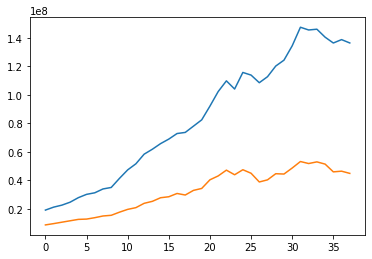

In [6]:
X = np.array(df.index).tolist()
y1 = df['People Worldwide'].astype('int')
y2 = df['People US'].astype('int')

plt.plot(X, y1, y2)
plt.show()

It looks like US user growth is flatlining in later years. We might have to apply a log transformation to validate if that's true.

Logarithmic user growth over time

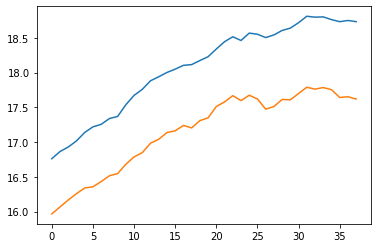

In [7]:
X_log = np.array(df.index).tolist()
y1_log = log(df['People Worldwide'].astype('int'))
y2_log = log(df['People US'].astype('int'))

plt.plot(X_log, y1_log, y2_log)
plt.show()

After applying a log-transform, it looks like US users are growing at the same rate as the rest of the world.

__Q1 It DOES NOT go to infinity__

In [8]:
from datetime import datetime

####
# Source: https://stackoverflow.com/questions/4039879/best-way-to-find-the-months-between-two-dates
# Args: two dates in datetime() format
# 
# Output: number of months in between dates provided
####
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [9]:
y1 = df['People US'].astype('int')

In [10]:
res = (y1.tolist()[-1] / y1.tolist()[0]) ** (1/len(y1))

In [11]:
temp_res = [y1.tolist()[-1]]
fac = res

for i in range(diff_month(datetime(2022,12,31), datetime(2013,5,31))):
    if i % 6 == 0:
        fac = fac * 0.99
    temp_res.append(temp_res[-1] * fac)

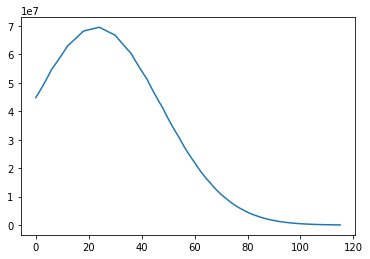

In [12]:
plt.plot(temp_res)
plt.show()

__Log growth approach__

In [13]:
wood = (log(y1.tolist()[-1]) - log(y1.tolist()[0])) / len(y1)

In [14]:
temp_res = [log(y1.tolist()[-1])]
fac = wood

for i in range(115):
    temp_res.append(temp_res[-1] + wood)

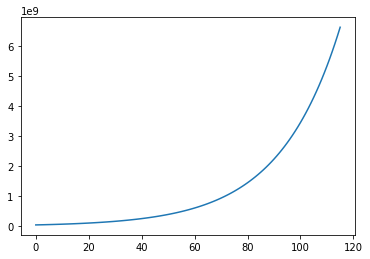

In [15]:
chop = [exp(x) for x in temp_res]

plt.plot(chop)
plt.show()

If we assume Tumblr will keep growing its global user base at the average 38-month growth rate, the site will have 53 billion active users.<br>

This obviously makes no sense, given that there are only 7 billion people in the world, and roughly 1/3 of that are children below 18 y.o. age.

__Q2 Getting over the hype__

Recall that the average monthly growth rate over the past 37 months = 

In [16]:
aag = 0

for i in range(len(y1)):
    if (i == 0) or (i+1 == 38):
        continue

    aag += ((y1[i+1] / y1[i]) - 1)
    
aag / len(y1)

0.04404548045270402

In [17]:
def calculate_amg(series, lookback_n):
    try:
        mon_g_total = 0
        start_idx = len(series) - lookback_n
        end_idx = len(series)

        for i in range(start_idx, end_idx):
            if (i == 0) or (i+1 == (end_idx)):
                continue

            mon_g_total += ((series[i+1] / series[i]) - 1)
        
        amg = mon_g_total / len(series)
        
        output = 'Avg. monthly growth rate for last ' + str(lookback_n) + ' mths: ' + str(amg)

        return output
    except:
        print('Check yoself before you wreck yoself.')

In [18]:
calculate_amg(y1, 38)

'Avg. monthly growth rate for last 38 mths: 0.04404548045270402'

In [19]:
calculate_amg(y1, 12)

'Avg. monthly growth rate for last 12 mths: 0.004392779951844175'

__Q3 Smooth operator... smoo-oo-ooth operator__

Boxcox

Sampling       :  26 / 38
Box Cox lambda : 0.22837013790269167


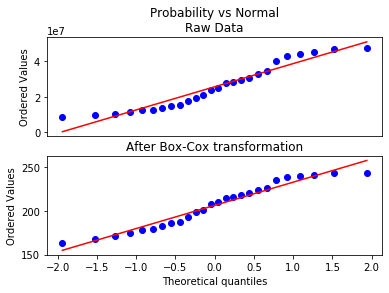


Box Cox Transform lambda : 0.228370
+---------+--------------------+--------------------+---------------------+
|   data  |        mean        |       st_dev       |     std to mean     |
+---------+--------------------+--------------------+---------------------+
|   Raw   | 25618706.115384616 | 12630582.56692938  |  0.493021876672547  |
| Box Cox | 206.06749935606615 | 25.329225784569935 | 0.12291713086110345 |
+---------+--------------------+--------------------+---------------------+


In [20]:
bc = boxcox.BoxCox(y1, test_size=.3)
bc.plot()

Text(0.5, 1.0, 'Air Passengers\nBox Cox (lambda=0.2284)')

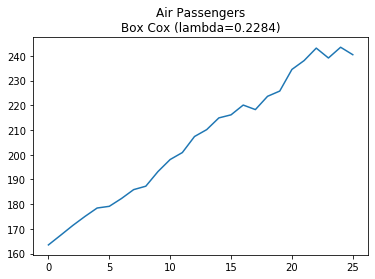

In [75]:
plt.plot(bc.Y)
plt.title('Air Passengers\nBox Cox (lambda=%6.4f)' % bc.lbda)

##### Fitting models to the data:

In [85]:
y2 = pd.DataFrame(bc.Y)[0]

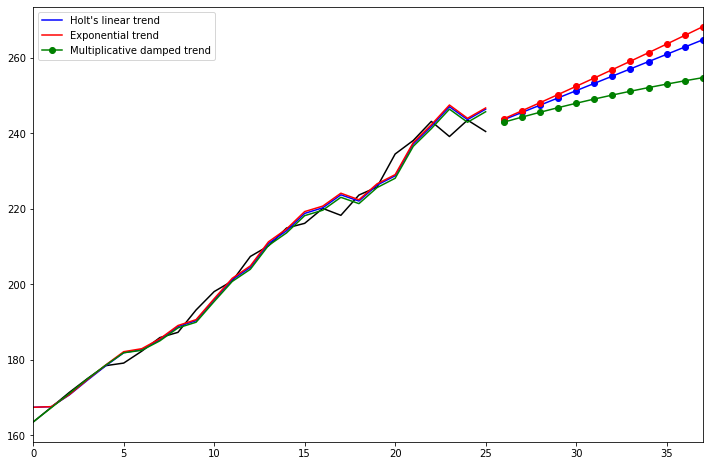

In [86]:
# adapted from https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html

fit1 = Holt(y2).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")
fit2 = Holt(y2, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast2 = fit2.forecast(12).rename("Exponential trend")
fit3 = Holt(y2, exponential=True, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast3 = fit3.forecast(12).rename("Multiplicative damped trend")

ax = y2.plot(color="black", figsize=(12,8))
fit1.fittedvalues.plot(ax=ax, color='blue')
fcast1.plot(ax=ax, color='blue', marker="o", legend=True)
fit2.fittedvalues.plot(ax=ax, color='red')
fcast2.plot(ax=ax, color='red', marker="o", legend=True)
fit3.fittedvalues.plot(ax=ax, color='green')
fcast3.plot(ax=ax, color='green', marker="o", legend=True)

plt.show()

![itsalive](https://media.giphy.com/media/UqUJhrD0om73q/giphy.gif)

Let's look at the root mean squared errors (RMSE) for each of these models:

In [87]:
from sklearn.metrics import mean_squared_error

rmse1 = sqrt(mean_squared_error(fit1.fittedvalues, y2))
rmse2 = sqrt(mean_squared_error(fit2.fittedvalues, y2))
rmse3 = sqrt(mean_squared_error(fit3.fittedvalues, y2))
print('RMSE Linear: %f' % rmse1)
print('RMSE Exponential: %f' % rmse2)
print('RMSE Multiplicative Damped: %f' % rmse3)

RMSE Linear: 2.915839
RMSE Exponential: 2.995438
RMSE Multiplicative Damped: 2.777340


After comparing the RMSE across the 3 models, the Multiplicative Damped Trend Model gave us the lowest RMSE, indicating that this model fitted our data best. Downstream, we will use this model to estimate cash flows.

__Q4 Cloudy with a Chance of Diminishing Returns__

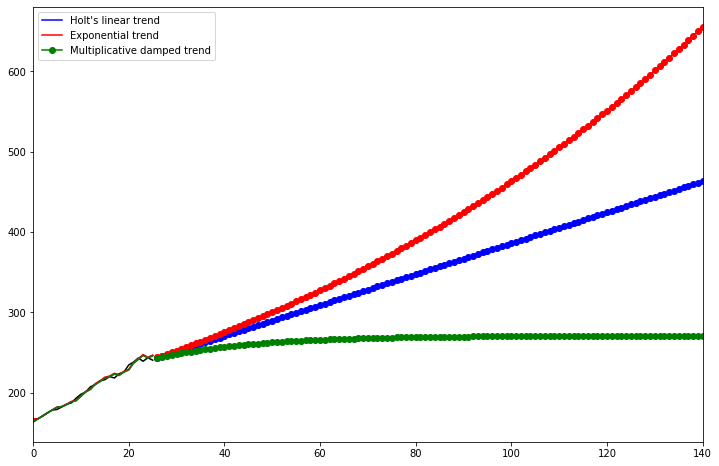

In [88]:
fit1 = Holt(y2).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1 = fit1.forecast(115).rename("Holt's linear trend")
fit2 = Holt(y2, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast2 = fit2.forecast(115).rename("Exponential trend")
fit3 = Holt(y2, exponential=True, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast3 = fit3.forecast(115).rename("Multiplicative damped trend")

ax = y2.plot(color="black", figsize=(12,8))
fit1.fittedvalues.plot(ax=ax, color='blue')
fcast1.plot(ax=ax, color='blue', marker="o", legend=True)
fit2.fittedvalues.plot(ax=ax, color='red')
fcast2.plot(ax=ax, color='red', marker="o", legend=True)
fit3.fittedvalues.plot(ax=ax, color='green')
fcast3.plot(ax=ax, color='green', marker="o", legend=True)

plt.show()

Outstanding

![Wow](https://media.giphy.com/media/BmmfETghGOPrW/giphy.gif)

__Introducing lagged variables__

Below is a nifty function to create lag variables very quickly:

In [22]:
def lag_variables(series, n, prefix = ''):
    ####
    # Input: series, n = number of lags
    # 
    # Output: list of tuples containing lag variables
    #
    # Downstream: to be added into main dataframe component for 
    #             further analysis / manipulation
    ####
    import pandas as pd
    assert n > 0
    try:
        temp_list = []
        col_d = {}
        for i in range(n):
            temp_list.append(tuple(series.shift(i + 1).tolist()))
            key = i
            col_name = 'lag' + str(i+1)
            
            if len(prefix) > 0:
                to_append = str(prefix) + '_'
                col_name = to_append + col_name
            
            if key not in col_d:
                col_d[i] = col_name
                
        df = pd.DataFrame(temp_list).transpose().rename(columns = col_d)
        
        return df
    except:
        print('Something went wrong when lagging variables.')
    